In [32]:
### Import Packages

# File manipulation

import os # For working with Operating System
import requests # Accessing the Web
import datetime as dt # Working with dates/times
import io # Input/Output Bytes objects
import json # Reading jsons
import time # Sleeping for API calls

# Analysis

import numpy as np
import pandas as pd


# Arc Stuff
import arcpy

# important as it "enhances" Pandas by importing these classes
from arcgis.features import GeoAccessor, GeoSeriesAccessor

In [24]:
# Set working Directory

# Get CWD

cwd = os.getcwd() # This is a global variable for where the notebook is (must change if running in arcpro)

# Create GeoDataBase
# This is the communal GeoDataBase, only run once

if not os.path.exists(os.path.join(cwd, '..', '..', '..', 'data', 'QAQC.gdb')): # If it doesn't exist, create it

    arcpy.management.CreateFileGDB(os.path.join(cwd, '..', '..', 'data'), 'QAQC')

# Make it workspace

arcpy.env.workspace = os.path.join(cwd, '..',  '..', '..', 'data', 'QAQC.gdb')

arcpy.env.overwriteOutput = True # Overwrite layers is okay

## Definitions

In [25]:
# Weather

def get_forecast(latlons):
    '''This function gets the forecast URL from National Weather Service's api
    and then gets the forecast for a list of lat/longs [(lat0,lon0),...]
    It also gets the current pressure for Minneapolis.
    
    It will return a dataframe of the forecasts with index aligning with the index of the latlons
    
    see here for API documentation:
    https://www.weather.gov/documentation/services-web-api
    '''

    # Initialize return value
    
    forecast_df = []

    # Define the headers for the request
    headers = {"Accept": "application/json"}
    
    # Get Local Current Pressure
    # Response is in Pascals, the conversion to millibars (PurpleAir Units) is 1/100
    
    pressure_response = requests.get('https://api.weather.gov/stations/KMSP/observations/latest',
                                     headers=headers)
    
    current_pressure = float(pressure_response.json()['properties']['barometricPressure']['value'])/100 
    
    # Define the URL to get gridpoints for the API endpoint
    gridpoint_url = "https://api.weather.gov/points/{lat},{lon}"
    
    for i, latlon in enumerate(latlons):
        
        lat = latlon[0]
        lon = latlon[1]
    
        # Send the request and get the response
        response = requests.get(gridpoint_url.format(lat=lat, lon=lon), headers=headers)

        # Check if the request was successful
        if response.status_code == 200:
            
            # Extract the forecast url from the response
            forecast_url = response.json()['properties']['forecast']

            forecast_response = requests.get(forecast_url, headers=headers)

            if forecast_response.status_code == 200:

                forecast_json = forecast_response.json()

                afternoon_df = pd.DataFrame(forecast_json['properties']['periods'][0])
                night_df = pd.DataFrame(forecast_json['properties']['periods'][1])

                full_df = pd.concat([afternoon_df, night_df]).loc['value'].reset_index()
                
                full_df['index'] = i
                full_df['pressure'] = current_pressure

                # Concatenate to the forecast_df
                
                if len(forecast_df) == 0:
                    
                    forecast_df = full_df
                    
                else:
                    
                    forecast_df = pd.concat([forecast_df, full_df], ignore_index = True)

        else:
            print("Request failed with status code {}".format(response.status_code))
            print("Error message: {}".format(response.text))

    return forecast_df

In [26]:
# PurpleAir Summary Functions

sum_fcts_path = os.path.join('..','Historic_PurpleAir', 'Summary_Functions.py')

with open(sum_fcts_path) as f:
    exec(f.read())

print('Stat Names:\n\n', summary_stats_names, '\n')
print('Stat Types:\n\n',summary_stats_dtypes, '\n')

print('Function Names:\n\n', summary_stats_functions)

Stat Names:

 ['n_observations', 'humidity_fullDay_mean', 'temperature_fullDay_mean', 'pressure_fullDay_mean', 'pm25_fullDay_mean', 'pm25_fullDay_min', 'pm25_fullDay_minTime', 'pm25_fullDay_max', 'pm25_fullDay_maxTime', 'pm25_fullDay_std', 'pm25_fullDay_minutesAbove12ug', 'pm25_morningRush_mean', 'pm25_morningRush_min', 'pm25_morningRush_minTime', 'pm25_morningRush_max', 'pm25_morningRush_maxTime', 'pm25_morningRush_std', 'pm25_eveningRush_mean', 'pm25_eveningRush_min', 'pm25_eveningRush_minTime', 'pm25_eveningRush_max', 'pm25_eveningRush_maxTime', 'pm25_eveningRush_std', 'pm25_daytimeAmbient_mean', 'pm25_daytimeAmbient_min', 'pm25_daytimeAmbient_minTime', 'pm25_daytimeAmbient_max', 'pm25_daytimeAmbient_maxTime', 'pm25_daytimeAmbient_std', 'pm25_nighttimeAmbient_mean', 'pm25_nighttimeAmbient_min', 'pm25_nighttimeAmbient_minTime', 'pm25_nighttimeAmbient_max', 'pm25_nighttimeAmbient_maxTime', 'pm25_nighttimeAmbient_std'] 

Stat Types:

 [<class 'int'>, <class 'float'>, <class 'float'>, <

In [27]:
# QAQC for PurpleAir

def qaqc(df):
    '''This function wil perform some basic QAQC
    '''
    
    clean_df = df.copy()
    
    # Convert timestamp to datetime
    
    clean_df['timestamp'] = pd.to_datetime(clean_df['timestamp'], unit='s')
    
    # Remove obvious error values
    
    clean_df = clean_df[clean_df.pm25 < 1000] 
    
    # Remove NaNs
    
    clean_df = clean_df.dropna()
    
    return clean_df

# Remove and record Spikes

def get_spikes(df, spike_threshold):
    '''This function removes spikes from a dataframe 
    and returns both the new dataframe
    and a separate spike dataframe
    '''
    
    df_w_spikes = df.copy()
    
    condition = (df.pm25 > spike_threshold)
    
    df_w_spikes['is_spike'] = condition
    
    spikes = df_w_spikes[condition].copy()
    
    return df_w_spikes, spikes

# Get Summary Stats

def get_summary_stats(df):
    ''' This is the main function. It will run all of our functions that get summary stats
    and return as a list.
    '''
    
    stats = []
    
    # Run the functions
    
    for f in summary_stats_functions:
        stats += f(df)
    
    return stats

## Data

In [28]:
# PurpleAir Stations

cwd = os.getcwd()

data_path = os.path.join(cwd,'..', '..', '..', 'data')

# Station Locations

stations_df = pd.read_csv(os.path.join(data_path, 'stations_5-2.csv'))

# Permitted Emissions

tablename = 'MPCA_Permitted_Emissions'

columns = [f.name for f in arcpy.ListFields(tablename)] #List the fields you want to include.

emissions = pd.DataFrame(data=arcpy.da.SearchCursor(tablename, columns), columns=columns)

current_pm_emissions = emissions[(emissions.YEAR == emissions.YEAR.max())
                                & (emissions.POLLUTANT == 'PM2.5 Primary')] # most recent PM2.5 Emissions

## Inverse Distance Weighted Sources

In [29]:
# Spatial Join

merge_fct_path = os.path.join('..','..','modeling','merge_dataFrame_w_featureClass.py')

with open(merge_fct_path) as f:
    exec(f.read())

help(merge_dataFrame_w_featureClass)

Help on function merge_dataFrame_w_featureClass in module __main__:

merge_dataFrame_w_featureClass(df, fc_name, new_name, left_on, right_on, field_types)
    df should be a pandas dataframe
    fc_name should be a string referring to a feature class in your GDB
    new_name should be a string for the new feature class
    left_on should be the field to merge from on the featureClass
    right_on should be the column to merge from the dataframe
    field_types should be a list of ESRI field types - 
    see https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/add-fields.htm



In [30]:
# Change Lat/lons into EPSG26915

# Create a list to store the values
coords_list = []

# Iterate over each row and add the WKT representation of a point geometry
for i, row in stations_df.iterrows():
    
    point = arcpy.Point(row['longitude'], row['latitude'])
    point_geom = arcpy.PointGeometry(point, arcpy.SpatialReference(4326))
    
    pt_utm = point_geom.projectAs(arcpy.SpatialReference(26915))
    
    stations_df.loc[i, 'X'] = pt_utm.firstPoint.X
    stations_df.loc[i, 'Y'] = pt_utm.firstPoint.Y

In [33]:
# Merge Current PM emissions with facility locations

merge_dataFrame_w_featureClass(current_pm_emissions, 'MPCA_Facilities', 
                               'current_pm_emissions',
                                   'FACILITY_ID',
                                   'FACILITY_ID',
                                  ['LONG', 'LONG', 'LONG', 'TEXT', 'FLOAT'])

emissions_geo = pd.DataFrame.spatial.from_featureclass('current_pm_emissions')

# Traffic

aadt_geo = pd.DataFrame.spatial.from_featureclass('clipped_aadt')

ERROR: Please delete or rename the feature class current_pm_emissions


In [35]:
# Iterate through the PurpleAir Stations to get weighted sums

idw_sum_dict = {} # Storage for results

# Facil
facilities_x = emissions_geo.SHAPE.apply(lambda x: x.x)
facilities_y = emissions_geo.SHAPE.apply(lambda x: x.y)

aadt_x = aadt_geo.SHAPE.apply(lambda x: x.centroid[0])
aadt_y = aadt_geo.SHAPE.apply(lambda x: x.centroid[1])

for i, sensor in stations_df.iterrows():
    
    # Initialize storage for results for this sensor
    
    idw_sum_dict[sensor.sensor_index] = {}
    
    sensor_x = sensor.X
    sensor_y = sensor.Y
    
    # Get distances to all facilities
    
    dists = np.sqrt((facilities_x-sensor_x)**2 + (facilities_y-sensor_y)**2)
    
    is_within = dists < 2000  # Within 2 km?
    
    # Sum those up
    
    idw_sum = np.sum(emissions_geo.LBS_EMITTED[is_within]/dists[is_within])
    
    idw_sum_dict[sensor.sensor_index]['Facilities'] = idw_sum
    
    # Get distances to all road centroids
    
    dists = np.sqrt((aadt_x-sensor_x)**2 + (aadt_y-sensor_y)**2)
    
    is_within = dists < 2000  # Within 2 km?
    
    # Sum those up
    
    idw_sum = np.sum(aadt_geo.CURRENT_VO[is_within]/dists[is_within])
    
    idw_sum_dict[sensor.sensor_index]['Traffic'] = idw_sum

## PurpleAir RealTime

In [7]:
spike_threshold = 28 # Micgrograms per meter cubed

In [8]:
# This is my personal API key... Please use responsibly!

api = input('Please enter your Purple Air api key')

Please enter your Purple Air api key 51592903-B445-11ED-B6F4-42010A800007


In [9]:
# Sensor Ids

sensor_ids = stations_df.sensor_index

### Query Strings

# Average string (in minutes) 1440 is 1 day average

avg_string = 'average=10'

# Environmental fields

env_fields = ['humidity', 'temperature', 'pressure','pm2.5_cf_1']

env_fields_string = 'fields=' + '%2C%20'.join(env_fields)

# My Header

my_headers = {'X-API-Key': api}

In [10]:
# Dates

today = dt.datetime.combine(dt.datetime.today(), dt.datetime.min.time()) # set to today @ midnight 
yesterday = today - dt.timedelta(days=1)

# Set up Timestamp for query    

start_timestamp = int(yesterday.timestamp())
end_timestamp = int(today.timestamp())

time_string = 'start_timestamp=' + str(start_timestamp) + '&end_timestamp=' + str(end_timestamp)

print('Last Run on ', today)

Last Run on  2023-05-07 00:00:00


In [11]:
## Initialize Storage

# Daily Summary

cols = ['sensor_index', 'date'] + summary_stats_names

datatypes = [int, str] + summary_stats_dtypes

dtypes = np.dtype(list(zip(cols, datatypes)))

daily_summary_df = pd.DataFrame(np.empty(0, dtype = dtypes))

# Spikes

all_spikes_df = pd.DataFrame(np.empty(0, dtype = [('sensor_index', int),
                                                  ('timestamp', pd._libs.tslibs.timestamps.Timestamp),
                                                  ('pm25', float)]
                                 )
                        )

In [36]:
# Iterate through the Sensors

starttime = dt.datetime.now()

for sensor_id in sensor_ids:

    ### Actual Loop

    time.sleep(3)

    # Base URL
    base_url = f'https://api.purpleair.com/v1/sensors/{sensor_id}/history/csv?'

    # Put it all together
    query_url = base_url + '&'.join([time_string, avg_string, env_fields_string])

    response = requests.get(query_url, headers=my_headers)

    if response.status_code == 200:

        # Read response as CSV data
        csv_data = response.content.decode('utf-8')

        if csv_data.count('\n') != 1: # There is not only one line (empty data)

            # Parse CSV data into pandas DataFrame
            df_individual_sensor = pd.read_csv(io.StringIO(csv_data),
                                               header=0
                                              )[['time_stamp', 'humidity', 'temperature', 
                                                 'pressure', 'pm2.5_cf_1']]

            df_individual_sensor.columns = ['timestamp', 'humidity', 'temperature', 
                                            'pressure', 'pm25']

            # Perform QAQC

            clean = qaqc(df_individual_sensor)

            # Remove Spikes & Concatenate to main storage of spikes

            clean_w_spikes, spikes = get_spikes(clean, spike_threshold)

            spikes['sensor_index'] = int(sensor_id)

            all_spikes_df = pd.concat([all_spikes_df, 
                                       spikes[['sensor_index',
                                                'timestamp',
                                                'pm25']]
                                      ],
                                       ignore_index=True)

            # Get Stats (With Spikes)

            sum_stats = get_summary_stats(clean_w_spikes)

            # Add to the daily summary dataframe

            row = [int(sensor_id), str(yesterday.date())] + sum_stats

            daily_summary_df.loc[len(daily_summary_df.index)] = row

    else:
        print(f"Error fetching data for sensor {sensor_id}: {response.status_code} on {yesterday.date()}")
        
print((dt.datetime.now() - starttime)/60, 'Minutes')

In [37]:
daily_summary_df.head()

,sensor_index,date,n_observations,humidity_fullDay_mean,temperature_fullDay_mean,pressure_fullDay_mean,pm25_fullDay_mean,pm25_fullDay_min,pm25_fullDay_minTime,pm25_fullDay_max,...,pm25_daytimeAmbient_minTime,pm25_daytimeAmbient_max,pm25_daytimeAmbient_maxTime,pm25_daytimeAmbient_std,pm25_nighttimeAmbient_mean,pm25_nighttimeAmbient_min,pm25_nighttimeAmbient_minTime,pm25_nighttimeAmbient_max,pm25_nighttimeAmbient_maxTime,pm25_nighttimeAmbient_std
0,11134,2023-05-06,124,0.000000,32.000000,0.000000,45.574121,19.793,05:10:00,810.975,...,12:30:00,52.525,13:30:00,5.505048,31.640263,21.393,00:30:00,41.094,02:50:00,6.831785
1,142718,2023-05-06,144,68.672917,63.864236,982.725035,22.433816,12.292,05:20:00,35.646,...,12:00:00,35.646,14:00:00,2.830054,21.113842,13.685,00:40:00,31.193,02:30:00,5.357278
2,142720,2023-05-06,144,63.409722,65.230556,982.836528,24.498799,13.422,05:20:00,82.376,...,14:50:00,33.599,12:50:00,1.940998,27.751947,21.538,00:30:00,35.411,02:20:00,4.036869
3,142726,2023-05-06,144,68.376389,63.580903,982.664819,23.131233,13.693,05:20:00,32.928,...,12:00:00,32.928,13:50:00,1.918977,22.911211,15.247,00:50:00,29.386,02:50:00,4.578084
4,142724,2023-05-06,144,69.530556,63.188889,983.037389,25.605021,15.241,00:10:00,37.994,...,14:50:00,37.994,13:20:00,2.41298,24.272632,15.241,00:10:00,34.266,02:50:00,6.690117


## Weather RealTime

In [38]:
# Format locations as latlons

lats = stations_df.latitude
lons = stations_df.longitude

latlons = list(zip(lats.to_list(), lons.to_list()))

In [39]:
# Get information
# Takes about 1 minute

starttime = dt.datetime.now()

forecast_df = get_forecast(latlons)

forecast_df.head()

print((dt.datetime.now() - starttime)/60, 'Minutes')

,index,number,name,startTime,endTime,isDaytime,temperature,temperatureUnit,temperatureTrend,probabilityOfPrecipitation,dewpoint,relativeHumidity,windSpeed,windDirection,icon,shortForecast,detailedForecast,pressure
0,0,1,Tonight,2023-05-07T22:00:00-05:00,2023-05-08T06:00:00-05:00,False,56,F,None,None,13.333333,88,5 mph,ENE,https://api.weather.gov/icons/land/night/bkn?s...,Mostly Cloudy,"Mostly cloudy, with a low around 56. East nort...",1010.5
1,0,2,Monday,2023-05-08T06:00:00-05:00,2023-05-08T18:00:00-05:00,True,71,F,None,None,12.222222,86,5 to 10 mph,E,https://api.weather.gov/icons/land/day/fog/bkn...,Areas Of Fog then Mostly Cloudy,"Areas of fog before 11am. Mostly cloudy, with ...",1010.5
2,2,1,Tonight,2023-05-07T22:00:00-05:00,2023-05-08T06:00:00-05:00,False,56,F,None,None,12.777778,88,0 to 5 mph,NE,https://api.weather.gov/icons/land/night/bkn?s...,Mostly Cloudy,"Mostly cloudy, with a low around 56. Northeast...",1010.5
3,2,2,Monday,2023-05-08T06:00:00-05:00,2023-05-08T18:00:00-05:00,True,71,F,None,None,11.666667,88,5 to 10 mph,E,https://api.weather.gov/icons/land/day/fog/bkn...,Areas Of Fog then Mostly Cloudy,"Areas of fog before 11am. Mostly cloudy, with ...",1010.5
4,3,1,Tonight,2023-05-07T22:00:00-05:00,2023-05-08T06:00:00-05:00,False,56,F,None,None,13.333333,88,5 mph,ENE,https://api.weather.gov/icons/land/night/bkn?s...,Mostly Cloudy,"Mostly cloudy, with a low around 56. East nort...",1010.5


In [40]:
# Narrow to the neccessary information and join with stations

daytime_forecast = forecast_df[forecast_df.isDaytime == True].set_index('index')

# This is the dataframe we will use to join with the others

stations_forecast_df = stations_df.copy()[['sensor_index']]

# Add humidity, temperature, pressure

stations_forecast_df['humidity_fullDay_mean'] = daytime_forecast.relativeHumidity.astype(float)
stations_forecast_df['temperature_fullDay_mean'] = daytime_forecast.temperature.astype(float)
stations_forecast_df['pressure_fullDay_mean'] = daytime_forecast.pressure.astype(float)

In [41]:
stations_forecast_df.head()

,sensor_index,humidity_fullDay_mean,temperature_fullDay_mean,pressure_fullDay_mean
0,3088,86.0,71.0,1010.5
1,11134,NaN,NaN,NaN
2,142718,88.0,71.0,1010.5
3,142720,86.0,71.0,1010.5
4,142726,88.0,71.0,1010.5


## Fill in Table

In [54]:
# Initialize Parameter Dataframe

cols = ['sensor_index', 'date', 'is_weekday', 'n_observations', 
              'pm25_fullDay_mean_yesterday', 'pm25_fullDay_minutesAbove12ug_yesterday',
              'n_spikes', 'humidity_fullDay_mean', 'temperature_fullDay_mean', 'pressure_fullDay_mean',
        'idwSum_facilities','idwSum_traffic'
             ]

datatypes = [int, dt.date, int, int,
             float, int,
             int, float, float, float,
            float, float]

dtypes = np.dtype(list(zip(cols, datatypes)))

modeling_df = pd.DataFrame(np.empty(0, dtype = dtypes))

In [55]:
# Iterable (date & sensor combinations)

# Select only day/sensors with more than 100 observations

select_summaries = daily_summary_df[(daily_summary_df.n_observations > 100)]

In [56]:
# Iterate

starttime = dt.datetime.now()

for i, sensor_id in enumerate(select_summaries.sensor_index):
    
    date = dt.datetime.today().date() # + dt.timedelta(days=1)
    
    is_weekday = int(date.weekday() < 5) # Checks if day of the week is a business day (0-4 = Mon-Fri, 5-6 = Sat-Sun)
    
    ## Select proper row of dataframes
    
    # Daily Summary
    day_sum = daily_summary_df.loc[(daily_summary_df.sensor_index == sensor_id)
                           ]#.iloc[0]
    
    # Historic PurpleAir
    
    weather_sum = stations_forecast_df.loc[stations_forecast_df.sensor_index == sensor_id]
    
    # Number of Spikes
                               
    day_spikes = all_spikes_df.loc[(all_spikes_df.sensor_index == sensor_id)]


    # Check if sensor has too many observations
    
    if (len(day_sum) > 1) & (len(weather_sum) > 1):
        
        print('too many observations for', date_sensor_combo)
    
    ## Check if day is observed
    
    elif (len(day_sum) == 1) & (len(weather_sum) == 1):
        
     # If yes, we record into modeling_df

        row = [sensor_id, date, is_weekday, day_sum.n_observations.iloc[0],
                  day_sum.pm25_fullDay_mean.iloc[0], day_sum.pm25_fullDay_minutesAbove12ug.iloc[0],
               len(day_spikes), weather_sum.humidity_fullDay_mean.iloc[0], weather_sum.temperature_fullDay_mean.iloc[0], weather_sum.pressure_fullDay_mean.iloc[0],
               idw_sum_dict[sensor_id]['Facilities'], idw_sum_dict[sensor_id]['Traffic']
              ]

        modeling_df.loc[len(modeling_df.index)] = row

print((dt.datetime.now() - starttime)/60, 'Minutes')

0:00:00.006133 Minutes


In [57]:
modeling_df

,sensor_index,date,is_weekday,n_observations,pm25_fullDay_mean_yesterday,pm25_fullDay_minutesAbove12ug_yesterday,n_spikes,humidity_fullDay_mean,temperature_fullDay_mean,pressure_fullDay_mean,idwSum_facilities,idwSum_traffic
0,11134,2023-05-07,0,124,45.574121,1240,83,NaN,NaN,NaN,0.000000,198.503282
1,142718,2023-05-07,0,144,22.433816,1440,18,88.0,71.0,1010.5,16.989008,743.057446
2,142720,2023-05-07,0,144,24.498799,1440,32,86.0,71.0,1010.5,41.154877,2133.686116
3,142726,2023-05-07,0,144,23.131233,1440,27,88.0,71.0,1010.5,40.121305,575.399052
4,142724,2023-05-07,0,144,25.605021,1440,51,86.0,71.0,1010.5,27.427867,384.946990
...,...,...,...,...,...,...,...,...,...,...,...,...
62,108366,2023-05-07,0,142,26.219454,1420,52,86.0,71.0,1010.5,1.770529,0.000000
63,110979,2023-05-07,0,144,22.920840,1440,23,85.0,71.0,1010.5,18.010888,967.695770
64,116413,2023-05-07,0,144,22.617743,1330,21,86.0,71.0,1010.5,52.912205,2320.135909
65,126487,2023-05-07,0,144,17.851326,1210,0,88.0,71.0,1010.5,2.939406,24.807636


## Predict

In [83]:
# Load the models

import json

model_basepath = os.path.join('..','..','modeling')

models = {}

for filename in os.listdir(model_basepath):
    
    if 'Model.geojson' in filename:
        
        model_name = filename.split('.')[0]
        
        model_path = os.path.join(model_basepath, filename)
        
        with open(model_path) as f:
    
            model_string = json.load(f)
        
        temp_featureSet = arcpy.FeatureSet(model_string, geojson_geometry_type = 'POINT')
        
        # Load into spatial dataframe
        
        columns = [f.name for f in arcpy.ListFields(temp_featureSet)] #List the fields you want to include
        
        models[model_name] = pd.DataFrame(data=arcpy.da.SearchCursor(temp_featureSet, columns), columns=columns)

In [110]:
# Use the Model

predictions = {}

for model_name in models:
    
    model = models[model_name]
    
    beta_names = [column for column in model.columns if '_beta' in column] # Get the betas from the model
    predictors = [beta_name[:-5] for beta_name in beta_names] # Get the column names for the predictors
    
    # Merge model with modeling_df
    
    merged = model.merge(modeling_df, on = 'sensor_index')
    merged['constant'] = 1 # Add a constant column
    
    # Apply the model
    
    betas = merged[beta_names].values
    X = merged[predictors].values
    
    merged['pm25_fullDay_mean_Prediction'] = np.sum(betas * X, axis = 1)
    
    predictions[model_name] = merged[['sensor_index', 'pm25_fullDay_mean_Prediction', 'longitude', 'latitude']]

AllSeasons_bestModel


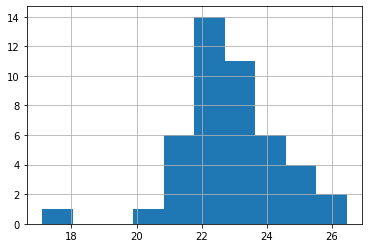

Fall_bestModel


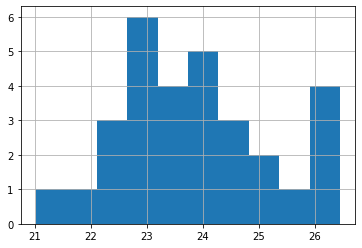

Spring_bestModel


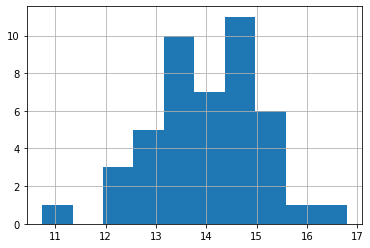

Summer_bestModel


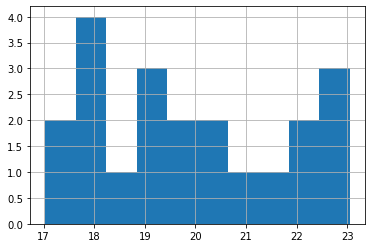

Winter_bestModel


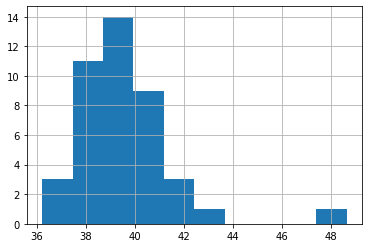

In [118]:
# Check 'em out?

import matplotlib.pyplot as plt

for model_name in predictions:
    
    print(model_name)
    
    prediction_df = predictions[model_name]
    
    prediction_df.pm25_fullDay_mean_Prediction.hist()
    
    plt.show()

In [115]:
# Save the results and pass to Taylor for interpolation

for model_name in predictions:
    
    prediction_df = predictions[model_name]
    
    savename = model_name + '_Predictions' + str(dt.datetime.today().date()) + '.csv'
    
    prediction_df.to_csv(savename, index = False)